<a href="https://colab.research.google.com/github/mahanama94/TF-lite-blog/blob/main/TF_Lite_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2021-12-20 Machine Learning on Mobile and Embedded Devices

Supplementary material for the blog post [2021-12-20 Machine Learning on Mobile and Embedded Devices](https://ws-dl.blogspot.com/2021/12/2021-12-20-machine-learning-on-mobile.html) on [Web Science and Digital Libraries Research Group Blog.](https://ws-dl.blogspot.com/)

For related articles and news:

* [Web Science and Digital Libraries Research Group](https://oduwsdl.github.io/)
* [Neuro-Information Retrieval and Data Science (NIRDS) Lab](https://nirdslab.github.io/)

Social media (Twitter):

* [@WebSciDL](https://twitter.com/WebSciDL)
* [@NirdsLab](https://twitter.com/NirdsLab)

YouTube: 

* [Nirds Lab](https://www.youtube.com/channel/UCWpcGyC2vCecKB5AFJWJ3ow)


For more detailed arttcles/tutorials:
* [TensorFlow Lite official guide](https://www.tensorflow.org/lite/guide)


In [1]:
import os
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
import numpy as np

# 
# Evaluation code credits: https://github.com/tensorflow/tensorflow (TensorFlow)
# Colab Notebook: https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_quant.ipynb#scrollTo=05aeAuWjvjPx
# Github : https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_quantization.md
# 
# 

def evaluate_model(interpreter, x_test, y_test):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(x_test):
    # if i % 1000 == 0:
    #   print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == y_test).mean()
  return accuracy

In [3]:
(x_train, y_train) , (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


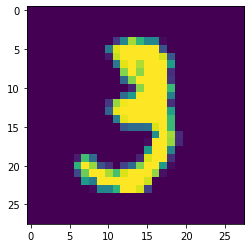

In [4]:
plt.imshow(x_train[10])

plt.show()

In [5]:
x_train = x_train/255

x_test = x_test / 255

## Base Model

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten

def get_base_model():
    return Sequential([
                        InputLayer(input_shape=(28, 28)),
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(32, activation='relu'),
                        Dense(10, activation='sigmoid')
    ])


base_model = get_base_model()

base_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

base_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2586 - accuracy: 0.9245
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1070 - accuracy: 0.9673
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0770 - accuracy: 0.9756
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0567 - accuracy: 0.9818
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0455 - accuracy: 0.9853


In [7]:
base_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0891 - accuracy: 0.9741


[0.08912268280982971, 0.9740999937057495]

In [8]:
base_model.save("base-mnist-model")

INFO:tensorflow:Assets written to: base-mnist-model/assets


## Post-training Quantization

In [9]:
tflite_converter = tf.lite.TFLiteConverter.from_saved_model("base-mnist-model")

### Non-Quantized Conversion

In [10]:
tflite_model = tflite_converter.convert()

NON_QUANTIZED_MODEL = "mnist-tflite-model.tflite"

with open(NON_QUANTIZED_MODEL, "wb") as model_file:
    model_file.write(tflite_model)

### Quantized Conversion

In [11]:
quantized_tflite_converter = tf.lite.TFLiteConverter.from_saved_model("base-mnist-model")

quantized_tflite_converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quantized_model = quantized_tflite_converter.convert()

QUANTIZED_MODEL = "mnist-tflite-quantized-model.tflite"

with open(QUANTIZED_MODEL, "wb") as model_file:
    model_file.write(tflite_quantized_model)

### Size Comparison

In [12]:
print(f'''TF Lite base model size : {os.path.getsize(NON_QUANTIZED_MODEL) / float(2**10)}
Quantized model size: {os.path.getsize(QUANTIZED_MODEL) / float(2**10)}''')

TF Lite base model size : 411.953125
Quantized model size: 106.15625


### Accuracy Comparison

In [13]:
interpreter = tf.lite.Interpreter(model_content=tflite_quantized_model)
interpreter.allocate_tensors()
quantized_tflite_model_accuracy = evaluate_model(interpreter, x_test, y_test)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
tflite_model_accuracy = evaluate_model(interpreter, x_test, y_test)

print(f'''TF Lite base model accuracy: {tflite_model_accuracy} 
Quantized model accuracy: {quantized_tflite_model_accuracy}''')

TF Lite base model accuracy: 0.974 
Quantized model accuracy: 0.9738


## Quantization Aware Training

In [14]:
!pip install tensorflow-model-optimization

     |████████████████████████████████| 213 kB 5.2 MB/s 


In [15]:
import tensorflow_model_optimization as tfmot

quantization_aware_model = tfmot.quantization.keras.quantize_model(
    get_base_model()
)

quantization_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

quantization_aware_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2594 - accuracy: 0.9248
Epoch 2/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1088 - accuracy: 0.9673
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0777 - accuracy: 0.9760
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0602 - accuracy: 0.9810
Epoch 5/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0468 - accuracy: 0.9852


### Accuracy Comparison

In [16]:
base_model_loss, base_model_accuracy = base_model.evaluate(x_test, y_test)

quantization_aware_model_loss, quantization_aware_model_accuracy = quantization_aware_model.evaluate(x_test, y_test)

print(f'''Base model accuracy: {base_model_accuracy}
Quantization aware model accuracy : {quantization_aware_model_accuracy}''')


313/313 [==============================] - 1s 3ms/step - loss: 0.0857 - accuracy: 0.9729
Base model accuracy: 0.9740999937057495
Quantization aware model accuracy : 0.9728999733924866


In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(quantization_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_aware_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp78h_e8ho/assets


INFO:tensorflow:Assets written to: /tmp/tmp78h_e8ho/assets


### Converted Model Accuracy Comparison

In [18]:
interpreter = tf.lite.Interpreter(model_content=quantized_aware_tflite_model)
interpreter.allocate_tensors()

quantized_aware_model_accuracy = evaluate_model(interpreter, x_test, y_test)

print(f'''Quantized model accuracy: {quantized_aware_model_accuracy} 
Quantization aware model accuracy: {quantization_aware_model_accuracy}
Base model accuracy: {base_model_accuracy}''')


Quantized model accuracy: 0.9336 
Quantization aware model accuracy: 0.9728999733924866
Base model accuracy: 0.9740999937057495


### Size Comparison

In [19]:
QUANTIZED_AWARE_MODEL = "mnist-tflite-quantized-aware-model.tflite"

with open(QUANTIZED_AWARE_MODEL, "wb") as model_file:
    model_file.write(quantized_aware_tflite_model)

print(f'''Non-quantized model size : {os.path.getsize(NON_QUANTIZED_MODEL) / float(2**10)}
Quantized model size (With Quantiaztion-aware training): {os.path.getsize(QUANTIZED_AWARE_MODEL) / float(2**10)}''')

Non-quantized model size : 411.953125
Quantized model size (With Quantiaztion-aware training): 106.09375


## Clustering

In [20]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(base_model, **clustering_params)

# `prune_low_magnitude` requires a recompile.
clustered_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

clustered_model.summary()

clustered_model.fit(x_train, y_train, epochs=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_flatten (ClusterWei  (None, 784)              0         
 ghts)                                                           
                                                                 
 cluster_dense (ClusterWeigh  (None, 128)              200848    
 ts)                                                             
                                                                 
 cluster_dense_1 (ClusterWei  (None, 32)               8240      
 ghts)                                                           
                                                                 
 cluster_dense_2 (ClusterWei  (None, 10)               666       
 ghts)                                                           
                                                                 
Total params: 209,754
Trainable params: 104,986
Non-trai

## Accuracy Comparison

In [21]:
clustered_model_loss, clustered_model_accuracy = clustered_model.evaluate(x_test, y_test)

print(f'''Base model accuracy : {base_model_accuracy}
Clustered model accuracy: {clustered_model_accuracy}''')

313/313 [==============================] - 5s 14ms/step - loss: 0.0965 - accuracy: 0.9735
Base model accuracy : 0.9740999937057495
Clustered model accuracy: 0.9735000133514404


In [22]:
CLUSTERED_MODEL = "mnist-tflite-clustered-model.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(tfmot.clustering.keras.strip_clustering(clustered_model))

clustered_tflite_model = converter.convert()

with open(CLUSTERED_MODEL, "wb") as model_file:
    model_file.write(clustered_tflite_model)



INFO:tensorflow:Assets written to: /tmp/tmp6szlzmkt/assets


INFO:tensorflow:Assets written to: /tmp/tmp6szlzmkt/assets


### Zipped Size Comparison

In [23]:
!zip  mnist-tflite-model.zip mnist-tflite-model.tflite
!zip  mnist-tflite-clustered-model.zip mnist-tflite-clustered-model.tflite
!ls -hs | grep zip

  adding: mnist-tflite-model.tflite (deflated 7%)
  adding: mnist-tflite-clustered-model.tflite (deflated 87%)
 56K mnist-tflite-clustered-model.zip
384K mnist-tflite-model.zip
